In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json
import datetime
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import initializers
from livelossplot import PlotLossesKeras

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14346449853121273371,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17905333686325546241
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5909348352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8524918575486884346
 physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5866871031808443700
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_pickle('../data/processed/simulation_results_10k.pickle')
df

,initial_country,idx_country,R0,Tc,Tr,omega,total_infected,total_death,total_recovered
0,LBN,106,7.490802,2.538351,19.014286,0.151272,1.387830e+10,1.041677e+10,3.621539e+09
1,GRL,74,11.937003,0.746976,8.916655,0.061480,1.433578e+10,5.165585e+09,9.422941e+09
2,MMR,130,6.674172,0.428118,2.857336,0.002080,1.432738e+10,8.502669e+07,1.430724e+10
3,TCD,37,19.398197,0.858268,16.648853,0.000078,1.439593e+10,1.870849e+07,1.442633e+10
4,GNQ,57,19.844231,0.622328,12.349630,0.074393,1.435014e+10,7.005585e+09,7.625351e+09
...,...,...,...,...,...,...,...,...,...
9995,KNA,172,3.051127,0.175870,0.536603,0.097821,1.429916e+10,9.762028e+08,1.859744e+10
9996,BIH,23,0.702684,13.698232,9.625529,0.043587,1.000000e+00,0.000000e+00,0.000000e+00
9997,SDN,175,0.838272,9.865214,8.269731,0.004503,1.000000e+00,0.000000e+00,0.000000e+00
9998,HUN,84,19.360133,0.948360,18.360371,0.029889,1.434934e+10,5.169317e+09,9.419837e+09


In [6]:
df.describe()

,idx_country,R0,Tc,Tr,omega,total_infected,total_death,total_recovered
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04
mean,101.649600,9.961199,10.807644,9.889748,0.100984,1.224645e+10,4.381650e+09,9.802043e+09
std,58.882425,5.785663,590.530415,5.707638,0.100687,4.692058e+09,3.561102e+09,3.775653e+10
min,0.000000,0.000111,0.000155,0.001951,0.000002,1.000000e+00,0.000000e+00,0.000000e+00
25%,51.000000,4.905381,0.497781,4.935927,0.030001,1.395681e+10,1.028010e+09,4.875866e+09
50%,102.000000,10.026822,0.990654,9.905077,0.070257,1.432583e+10,3.834818e+09,8.535535e+09
75%,152.250000,14.912676,1.995541,14.739758,0.140886,1.434903e+10,7.267127e+09,1.182062e+10
max,204.000000,19.996334,58779.388647,19.989358,1.055234,1.446550e+10,1.332664e+10,2.424226e+12


<AxesSubplot:ylabel='Frequency'>

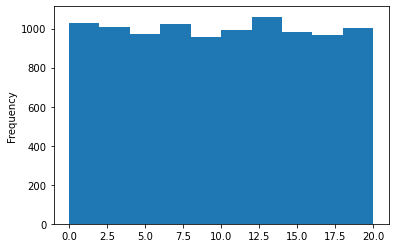

In [7]:
df['R0'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

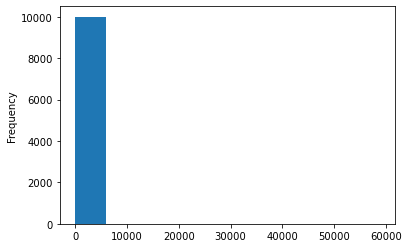

In [8]:
df['Tc'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

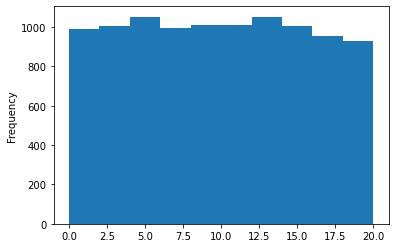

In [9]:
df['Tr'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

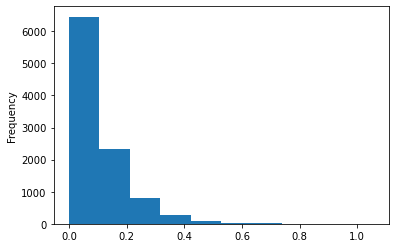

In [10]:
df['omega'].plot(kind='hist')

In [11]:
with open('../data/interim/alpha3_to_alpha2.txt', 'r') as file:
    alpha3_to_alpha2 = json.load(file)
    
graph = nx.read_gpickle('../data/interim/routes_countries.gpickle')

degree = dict(nx.degree_centrality(graph))
betw = nx.betweenness_centrality(graph)
closeness = nx.closeness_centrality(graph)

df['iso2'] = df['initial_country'].map(alpha3_to_alpha2)
df['betweenness'] = df['iso2'].map(betw)
df['degree'] = df['iso2'].map(degree)
df['closeness'] = df['iso2'].map(closeness)
df.head()

,initial_country,idx_country,R0,Tc,Tr,omega,total_infected,total_death,total_recovered,iso2,betweenness,degree,closeness
0,LBN,106,7.490802,2.538351,19.014286,0.151272,1.387830e+10,1.041677e+10,3.621539e+09,LB,0.001057,0.270270,0.460581
1,GRL,74,11.937003,0.746976,8.916655,0.061480,1.433578e+10,5.165585e+09,9.422941e+09,GL,0.000058,0.027027,0.356340
2,MMR,130,6.674172,0.428118,2.857336,0.002080,1.432738e+10,8.502669e+07,1.430724e+10,MM,0.000069,0.117117,0.393617
3,TCD,37,19.398197,0.858268,16.648853,0.000078,1.439593e+10,1.870849e+07,1.442633e+10,TD,0.000064,0.058559,0.408088
4,GNQ,57,19.844231,0.622328,12.349630,0.074393,1.435014e+10,7.005585e+09,7.625351e+09,GQ,0.000072,0.063063,0.391534


In [12]:
df['total_death'] = df['total_death'] / 1000

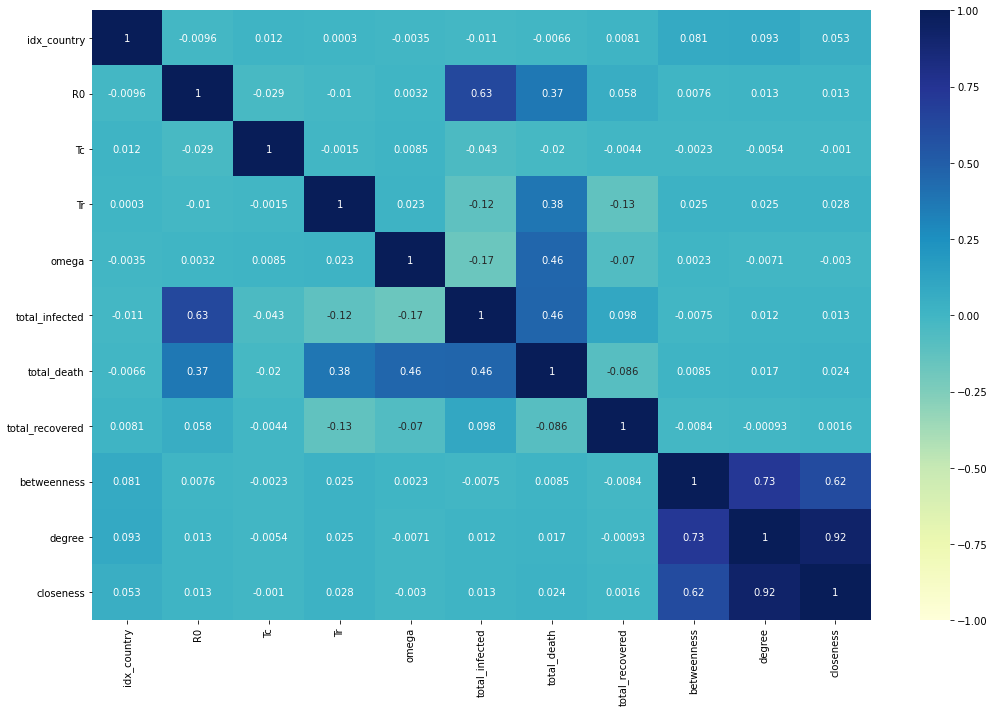

In [13]:
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, cmap="YlGnBu", ax=ax)
plt.tight_layout()

In [14]:
df_model = df[['R0', 'Tc', 'Tr', 'omega', 'total_death', 'betweenness', 'degree', 'closeness']]
df_model

,R0,Tc,Tr,omega,total_death,betweenness,degree,closeness
0,7.490802,2.538351,19.014286,0.151272,1.041677e+07,0.001057,0.270270,0.460581
1,11.937003,0.746976,8.916655,0.061480,5.165585e+06,0.000058,0.027027,0.356340
2,6.674172,0.428118,2.857336,0.002080,8.502669e+04,0.000069,0.117117,0.393617
3,19.398197,0.858268,16.648853,0.000078,1.870849e+04,0.000064,0.058559,0.408088
4,19.844231,0.622328,12.349630,0.074393,7.005585e+06,0.000072,0.063063,0.391534
...,...,...,...,...,...,...,...,...
9995,3.051127,0.175870,0.536603,0.097821,9.762028e+05,0.000724,0.045045,0.388112
9996,0.702684,13.698232,9.625529,0.043587,0.000000e+00,0.000007,0.090090,0.403636
9997,0.838272,9.865214,8.269731,0.004503,0.000000e+00,0.000296,0.108108,0.411874
9998,19.360133,0.948360,18.360371,0.029889,5.169317e+06,0.000300,0.297297,0.469345


In [15]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (7500, 7)
Test set: (2500, 7)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [18]:
# inputs = Input(X_train_scaled.shape[1:])
# h0 = Dense(20, activation='relu')(inputs)
# h1 = Dense(10, activation='relu')(h0)
# preds = Dense(1)(h1)

# model = Model(inputs, preds)
# sgd = Adam(lr=0.0001)
# model.compile(optimizer=sgd, loss= 'mean_squared_error', metrics=['mean_absolute_percentage_error'])
# history = model.fit(X_train_scaled, y_train.values, batch_size=128, epochs=50, verbose=0,
#                     validation_data=(X_test_scaled, y_test.values),
#                    callbacks=[PlotLossesKeras()])

# score_train = model.evaluate(X_train_scaled, y_train.values, verbose=0)
# score_test = model.evaluate(X_test_scaled, y_test.values, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAPE:', score_train[1])
# print('Test score:', score_test[0])
# print('Test MAPE:', score_test[1])

In [19]:
# model.summary()

# MODELO 2

In [20]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (7500, 7)
Test set: (2500, 7)


In [21]:
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [22]:
# inputs = Input(X_train_scaled.shape[1:])
# h0 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(inputs)
# h1 = Dense(30, activation='selu', kernel_initializer='lecun_normal')(h0)
# h2 = Dense(10, activation='selu', kernel_initializer='lecun_normal')(h1)
# preds = Dense(1)(h2)

# model = Model(inputs, preds)
# sgd = Nadam(lr=0.0001)
# model.compile(optimizer=sgd, loss= 'mean_squared_error', metrics=['mean_absolute_percentage_error'])
# history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=0,
#                     validation_data=(X_test, y_test),
#                    callbacks=[PlotLossesKeras()])

# score_train = model.evaluate(X_train, y_train, verbose=0)
# score_test = model.evaluate(X_test, y_test, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAPE:', score_train[1])
# print('Test score:', score_test[0])
# print('Test MAPE:', score_test[1])

In [23]:
# model.summary()

# TENSORBOARD

In [24]:
import os
import time
root_logdir_tensorboard = os.path.join(os.curdir, "my_logs")
root_logdir_checkpoints = os.path.join(os.curdir, "checkpoints")

In [25]:
# !rm -rf ./my_logs

In [26]:
# %load_ext tensorboard

In [27]:
# !tensorboard --logdir=./my_logs --port=6006

In [ ]:
dense_layers = [2, 3, 4]
layer_sizes = [3, 5, 7]

# dense_layers = [2]
# layer_sizes = [10]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        run_time = time.strftime("run_%d_%m_%Y-%H_%M_%S")
        NAME = f"{dense_layer}-layers-{layer_size}-nodes-{run_time}"
        print(NAME)
        model = Sequential()
        inputs = Input(X_train.shape[1:])
        
        for l in range(dense_layer-1):
            model.add(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
        
        model.add(Dense(1))
        
        tensorboard_cb = keras.callbacks.TensorBoard(f"{root_logdir_tensorboard}/{NAME}")
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        checkpoint_cb = keras.callbacks.ModelCheckpoint(f"{root_logdir_checkpoints}/{NAME}.h5",
                                                       save_best_only=True)

        model.compile(optimizer=Nadam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
        
        history = model.fit(X_train, y_train, epochs=500, verbose=0,
                            validation_data=(X_test, y_test),
                           callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb])

        score_train = model.evaluate(X_train, y_train, verbose=0)
        score_test = model.evaluate(X_test, y_test, verbose=0)

        print('Train score:', score_train[0])
        print('Train MAPE:', score_train[1])
        print('Test score:', score_test[0])
        print('Test MAPE:', score_test[1])
        print('========')

2-layers-3-nodes-run_12_08_2020-18_17_34
Train score: 26079710412800.0
Train MAPE: 3916336.5
Test score: 24480766230528.0
Test MAPE: 3751703.0
2-layers-5-nodes-run_12_08_2020-18_23_20


In [ ]:
def get_run_logdir():
#     import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir_tensorboard, run_id)

run_logdir = get_run_logdir()

In [ ]:
# inputs = Input(X_train_scaled.shape[1:])
# h0 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(inputs)
# h1 = Dense(30, activation='selu', kernel_initializer='lecun_normal')(h0)
# h2 = Dense(10, activation='selu', kernel_initializer='lecun_normal')(h1)
# preds = Dense(1)(h2)

# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5')

# model = Model(inputs, preds)
# sgd = Nadam()
# model.compile(optimizer=sgd, loss= 'mean_squared_error', metrics=['mean_absolute_error'])
# history = model.fit(X_train, y_train, epochs=10000, verbose=0,
#                     validation_data=(X_test, y_test),
#                    callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb])

# score_train = model.evaluate(X_train, y_train, verbose=0)
# score_test = model.evaluate(X_test, y_test, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAPE:', score_train[1])
# print('Test score:', score_test[0])
# print('Test MAPE:', score_test[1])
# print('========')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
y_pred.shape

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
model.save('saved_model/nn_10k') 